In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import time

# IMPORT

In [28]:
# df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
# df.head()

,Title,Userscore,Comment
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it..."
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...


In [35]:
df = pickle.load(open('processed_df\preprocessed_nlp_30p.pkl','rb'))
df.head()

,Title,Userscore,Comment,lang
211190,Star Wars: Battlefront II,2.0,there nothing quite gun entire platoon clone d...,en
39249,The Witcher 3: Wild Hunt,10.0,game absolutely gorgeous run steady gtx hairwo...,en
204931,This War of Mine,10.0,really good game didnt expect first survival g...,en
75752,Golden Sun,10.0,people eagerly anticipate initial release game...,en
199503,Assassin's Creed IV: Black Flag,8.0,best assassin creed far open world fresh missi...,en


In [36]:
df.to_csv(r'processed_df\preprocessed_nlp_30p.csv', index = False)

# Train test split

In [37]:
X = df['Comment']
y = df['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# NB

- baseline

In [71]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('multinb', MultinomialNB())]
NB_pipeline = Pipeline(steps)

In [72]:
NB_pipeline.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [73]:
y_pred = NB_pipeline.predict(transformed_te)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00        24
         3.0       0.00      0.00      0.00        46
         4.0       0.00      0.00      0.00        49
         5.0       0.00      0.00      0.00        48
         6.0       0.00      0.00      0.00        75
         7.0       0.00      0.00      0.00       103
         8.0       0.67      0.02      0.05       169
         9.0       0.18      0.01      0.01       307
        10.0       0.42      1.00      0.59       628

    accuracy                           0.42      1500
   macro avg       0.13      0.10      0.07      1500
weighted avg       0.29      0.42      0.26      1500



c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


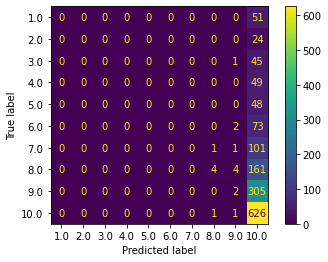

In [75]:
plot_confusion_matrix(NB_pipeline, transformed_te, y_test)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


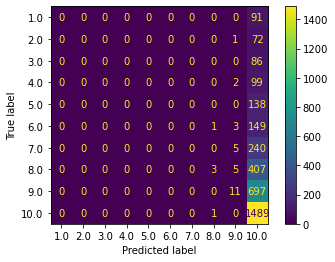

In [83]:
plot_confusion_matrix(NB_pipeline, transformed_tr, y_train)

# Random Forest

- baseline

In [38]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestRegressor())]
rf_pipeline = Pipeline(steps)

In [39]:
start = time.time()

rf_pipeline.fit(X_train, y_train)

end = time.time()
print(f'{end-start} secs slipped..')

1164.5206515789032 secs slipped..


In [40]:
y_rf_pred = rf_pipeline.predict(X_test)

In [15]:
rf_pipeline.score(X_test,y_test)


0.20206640425757916

In [17]:
from sklearn.metrics import mean_squared_error
  
mean_squared_error(y_test,y_rf_pred)

4.536851226003104

In [18]:
mean_squared_error(y_train,rf_pipeline.predict(X_train))

0.8477250857157115

In [82]:
# seems like overfit

- simple man tune

In [29]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestClassifier(max_depth=16))]
rf_pipeline_m = Pipeline(steps)

In [30]:
rf_pipeline_m.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('random forest', RandomForestClassifier(max_depth=16))])

In [31]:
y_pred = rf_pipeline_m.predict(X_test)

In [32]:
rf_pipeline_m.score(X_test,y_test)

0.42237687366167026

In [33]:
mean_squared_error(y_test,rf_pipeline_m.predict(X_test))

8.432548179871521

In [34]:
mean_squared_error(y_train,rf_pipeline_m.predict(X_train))

5.658978772231785